In [1]:
import os
import glob
from copy import deepcopy
from utils.params import dict_update
from dataset.utils.homographic_augmentation import homographic_aug_pipline
from dataset.utils.photometric_augmentation import PhotoAugmentor
from utils.keypoint_op import compute_keypoint_map
from dataset.utils.photometric_augmentation import *
from torchvision import transforms
from torch.utils.data import DataLoader
from solver.sfm_loss import *
import yaml
import matplotlib.pyplot as plt

In [2]:
class SelfDataset(torch.utils.data.Dataset):

    def __init__(self, config, is_train, device='cpu'):

        super(SelfDataset, self).__init__()
        self.device = device
        self.is_train = is_train
        self.resize = tuple(config['resize'])
        self.photo_augmentor = PhotoAugmentor(config['augmentation']['photometric'])
        self.config = config
        if self.is_train:
            self.samples = self._init_data(config['image_train_path'], config['label_train_path'], config['pairs_train_path'])
        else:
            self.samples = self._init_data(config['image_test_path'], config['label_test_path'], config['pairs_test_path'])


    def _init_data(self, image_path, label_path=None, pair_path=None):
        ##
        if not isinstance(image_path,list):
            image_paths, label_paths, pair_paths = [image_path,], [label_path,], [pair_path,]
        else:
            image_paths, label_paths, pair_paths = image_path, label_path, pair_path

        image_types = ['jpg','jpeg','bmp','png']
        samples = []
        for im_path, lb_path, pair_path in zip(image_paths, label_paths, pair_paths):
            pairs = np.load(os.path.join(pair_path, 'pairs.npy'), allow_pickle=True)
            pairs = pairs.item()
            templist = ['1377155868.png']
            for key in templist:
                filename = key.split(".")[0]
                temp_im = os.path.join(im_path, key)
                if lb_path is not None:
                    temp_lb = os.path.join(lb_path, filename+'.npy')
                else:
                    temp_lb = None
                for i in range(len(pairs[key]['pairs'])):
                    pair = pairs[key]['pairs'][i]
                    filename = pair.split(".")[0]
                    covisibility = pairs[key]['covisibility'][i]
                    index = pairs[key]['index'][i]
                    temp_im1 = os.path.join(im_path, pair)
                    if lb_path is not None:
                        temp_lb1 = os.path.join(lb_path, filename+'.npy')
                    else:
                        temp_lb1 = None
                    samples.append({'image':temp_im, 'label':temp_lb, 'image1':temp_im1, 'label1': temp_lb1, 'index': index, 'covisibility': covisibility})
        return samples

    def __len__(self):
        return len(self.samples)


    def __getitem__(self, idx):
        '''load raw data'''
        
        data_path = self.samples[idx]
        
         # load images
        img = cv2.imread(data_path['image'], 0)#Gray image
        img = cv2.resize(img, self.resize[::-1])
        img_tensor = torch.as_tensor(img.copy(), dtype=torch.float, device=self.device)
        img1 = cv2.imread(data_path['image1'], 0)#Gray image
        img1 = cv2.resize(img1, self.resize[::-1])
        img_tensor1 = torch.as_tensor(img1.copy(), dtype=torch.float, device=self.device)

        pts = None if data_path['label'] is None else np.load(data_path['label'])[:, [1,0,2]]
        pts1 = None if data_path['label1'] is None else np.load(data_path['label1'])[:, [1,0,2]]
        pts[:, 0] = (pts[:, 0]+0.5)/1200*self.resize[0]
        pts[:, 1] = (pts[:, 1]+0.5)/1920*self.resize[1]
        pts1[:, 0] = (pts1[:, 0]+0.5)/1200*self.resize[0]
        pts1[:, 1] = (pts1[:, 1]+0.5)/1920*self.resize[1]
        
        kpts_tensor = None if pts is None else torch.as_tensor(pts, device=self.device)
        kpts_tensor1 = None if pts1 is None else torch.as_tensor(pts1, device=self.device)
        
        # compute maps
        kpts_map = None if pts is None else compute_keypoint_map(kpts_tensor, img.shape, device=self.device, id_included=True)
        kpts_map1 = None if pts1 is None else compute_keypoint_map(kpts_tensor1, img1.shape, device=self.device, id_included=True)
        valid_mask = torch.ones(img.shape, device=self.device)
        valid_mask1 = torch.ones(img1.shape, device=self.device)
        

        data = {    'image':{'raw':{'img': img_tensor,
                                    'kpts': kpts_tensor,
                                    'kpts_map':kpts_map,
                                    'mask': valid_mask},
                            'warp':{'img': None,
                                    'kpts': None,
                                    'kpts_map':None,
                                    'mask': None},
                            'homo': torch.eye(3,device=self.device)},
                    'image1':{'raw':{'img': img_tensor1,
                                    'kpts': kpts_tensor1,
                                    'kpts_map':kpts_map1,
                                    'mask': valid_mask1},
                            'warp':{'img': None,
                                    'kpts': None,
                                    'kpts_map':None,
                                    'mask': None},
                            'homo': torch.eye(3,device=self.device)}, 
                    'pairs': None      
                }
        
        # compute warpings
        data['image']['warp'] = deepcopy(data['image']['raw'])
        data['image1']['warp'] = deepcopy(data['image1']['raw'])
        
        if self.is_train:
            photo_enable = self.config['augmentation']['photometric']['train_enable']
            homo_enable = self.config['augmentation']['homographic']['train_enable']
        else:
            photo_enable = self.config['augmentation']['photometric']['test_enable']
            homo_enable = self.config['augmentation']['homographic']['test_enable']

        if homo_enable and data['image']['raw']['kpts'] is not None and data['image1']['raw']['kpts'] is not None:#homographic augmentation
            data_homo = homographic_aug_pipline(data['image']['warp']['img'],
                                                data['image']['warp']['kpts'],
                                                self.config['augmentation']['homographic'],
                                                device=self.device, id_included=True)
            data_homo1 = homographic_aug_pipline(data['image1']['warp']['img'],
                                                data['image1']['warp']['kpts'],
                                                self.config['augmentation']['homographic'],
                                                device=self.device, id_included=True)
            data['image'].update(data_homo)
            data['image1'].update(data_homo1)
            
        if photo_enable:
            photo_img = data['image']['warp']['img'].cpu().numpy().round().astype(np.uint8)
            photo_img = self.photo_augmentor(photo_img)
            data['image']['warp']['img'] = torch.as_tensor(photo_img, dtype=torch.float,device=self.device)
            photo_img1 = data['image1']['warp']['img'].cpu().numpy().round().astype(np.uint8)
            photo_img1 = self.photo_augmentor(photo_img1)
            data['image1']['warp']['img'] = torch.as_tensor(photo_img1, dtype=torch.float,device=self.device)
        
        # compute new pairs and index
        pairs_dict = dict.fromkeys(data_path['covisibility'], -1)
        index_dict = dict.fromkeys(data_path['index'], -1)
        pairs_list = data_path['covisibility']
        index_list = data_path['index']
        pairs = []
        index = []
        
        for i, x in enumerate(data['image']['warp']['kpts']):
            if int(x[2]) in index_dict:
                index_dict[int(x[2])] = i
        for i, x in enumerate(data['image1']['warp']['kpts']):
            if int(x[2]) in pairs_dict:
                pairs_dict[int(x[2])] = i
        
        for i in range(len(pairs_list)):
            if pairs_dict[pairs_list[i]] != -1 and index_dict[index_list[i]] != -1:
                pairs.append([index_dict[index_list[i]], pairs_dict[pairs_list[i]]])
        
        data['pairs'] = torch.as_tensor(np.array(pairs).astype(np.int), device=self.device)
        
        # remove the old index from points & normalize images
        for image_flag in ['image','image1']:
            for warp_flag in ['raw','warp']:
                data[image_flag][warp_flag]['kpts'] = data[image_flag][warp_flag]['kpts'][:,:2].int()
                data[image_flag][warp_flag]['img'] = data[image_flag][warp_flag]['img']/255.
        
        return data
    

    def batch_collator(self, samples):
        """
        :param samples:a list, each element is a dict with keys
        like `img`, `img_name`, `kpts`, `kpts_map`,
        `valid_mask`, `homography`...
        img:H*W, kpts:N*2, kpts_map:HW, valid_mask:HW, homography:HW
        :return:
        """
#         sub_data={  'raw':{ 'img':      [],
#                             'kpts':     [],
#                             'kpts_map': [],
#                             'mask':     []},
#                     'warp':{'img':      [],
#                             'kpts':     [],
#                             'kpts_map': [],
#                             'mask':     []},
#                     'homo':             []}
        sub_data={  'raw':{ 'img':      [],
                            'kpts':     [],
                            'kpts_map': []},
                    'warp':{'img':      [],
                            'kpts':     [],
                            'kpts_map': []}}
        batch = {'image':deepcopy(sub_data), 'image1':deepcopy(sub_data), 'masks': [], 'pairs': []}
        for s in samples:
            batch['pairs'].append(s['pairs'])
            batch['image']['raw']['img'].append(s['image']['raw']['img'].unsqueeze(dim=0))
            batch['image']['raw']['kpts'].append(s['image']['raw']['kpts'])
            batch['image']['raw']['kpts_map'].append(s['image']['raw']['kpts_map'])
#             batch['image']['raw']['mask'].append(s['image']['raw']['mask'])
            batch['image']['warp']['img'].append(s['image']['warp']['img'].unsqueeze(dim=0))
            batch['image']['warp']['kpts'].append(s['image']['warp']['kpts'])
            batch['image']['warp']['kpts_map'].append(s['image']['warp']['kpts_map'])
#             batch['image']['warp']['mask'].append(s['image']['warp']['mask'])
#             batch['image']['homo'].append(s['image']['homo'])
            batch['image1']['raw']['img'].append(s['image1']['raw']['img'].unsqueeze(dim=0))
            batch['image1']['raw']['kpts'].append(s['image1']['raw']['kpts'])
            batch['image1']['raw']['kpts_map'].append(s['image1']['raw']['kpts_map'])
#             batch['image1']['raw']['mask'].append(s['image1']['raw']['mask'])
            batch['image1']['warp']['img'].append(s['image1']['warp']['img'].unsqueeze(dim=0))
            batch['image1']['warp']['kpts'].append(s['image1']['warp']['kpts'])
            batch['image1']['warp']['kpts_map'].append(s['image1']['warp']['kpts_map'])
            batch['masks'].append(torch.stack((s['image']['warp']['mask'], s['image']['warp']['mask']), dim=0))
#             batch['image1']['warp']['mask'].append(s['image1']['warp']['mask'])
#             batch['image1']['homo'].append(s['image1']['homo'])
        batch['masks'] = torch.stack(batch['masks'])
        for k0 in ('image','image1'):
#             batch[k0]['homo'] = torch.stack(batch[k0]['homo'])
            for k1 in ('raw','warp'):
                for k2 in ('img', 'kpts_map'):
                    batch[k0][k1][k2] = torch.stack(batch[k0][k1][k2])
        return batch

0 {'image': {'raw': {'img': tensor([[[[0.0941, 0.0784, 0.0784,  ..., 0.0431, 0.0627, 0.0510],
          [0.0863, 0.0784, 0.0784,  ..., 0.0510, 0.0549, 0.0471],
          [0.0706, 0.0667, 0.0667,  ..., 0.0431, 0.0588, 0.0431],
          ...,
          [0.0941, 0.0863, 0.0941,  ..., 0.0588, 0.0510, 0.0431],
          [0.0902, 0.0941, 0.0902,  ..., 0.0588, 0.0431, 0.0431],
          [0.0941, 0.0941, 0.0902,  ..., 0.0431, 0.0471, 0.0510]]]]), 'kpts': [tensor([[  1,  47],
        [  1,  47],
        [  2, 181],
        ...,
        [ 24, 218],
        [193, 208],
        [ 88, 231]], dtype=torch.int32)], 'kpts_map': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32)}, 'warp': {'img': tensor([[[[0.3216, 0.3412, 0.3216,  ..., 0.4667, 0.4745, 0.4824],
          [0.3255, 0.3451, 0.3216,  ..., 0.4667, 0.4

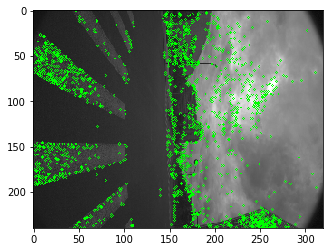

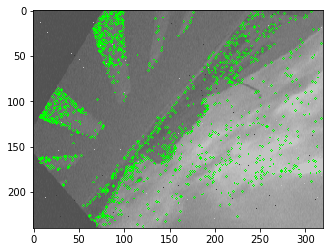

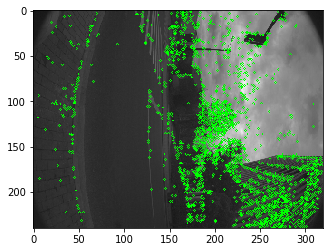

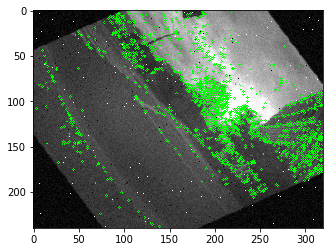

1 {'image': {'raw': {'img': tensor([[[[0.0941, 0.0784, 0.0784,  ..., 0.0431, 0.0627, 0.0510],
          [0.0863, 0.0784, 0.0784,  ..., 0.0510, 0.0549, 0.0471],
          [0.0706, 0.0667, 0.0667,  ..., 0.0431, 0.0588, 0.0431],
          ...,
          [0.0941, 0.0863, 0.0941,  ..., 0.0588, 0.0510, 0.0431],
          [0.0902, 0.0941, 0.0902,  ..., 0.0588, 0.0431, 0.0431],
          [0.0941, 0.0941, 0.0902,  ..., 0.0431, 0.0471, 0.0510]]]]), 'kpts': [tensor([[  1,  47],
        [  1,  47],
        [  2, 181],
        ...,
        [ 24, 218],
        [193, 208],
        [ 88, 231]], dtype=torch.int32)], 'kpts_map': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32)}, 'warp': {'img': tensor([[[[0.1298, 0.1260, 0.0914,  ..., 0.0675, 0.0453, 0.0161],
          [0.0688, 0.0828, 0.1106,  ..., 0.1092, 0.0

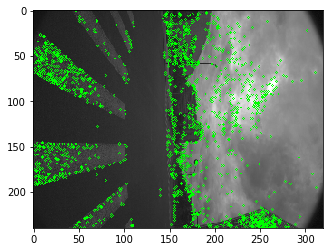

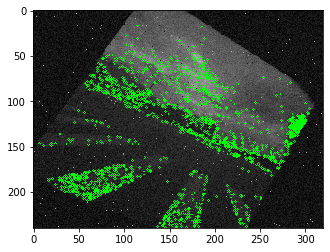

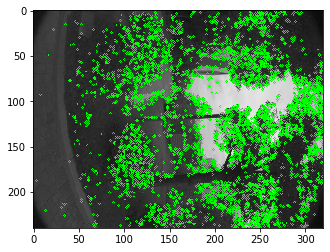

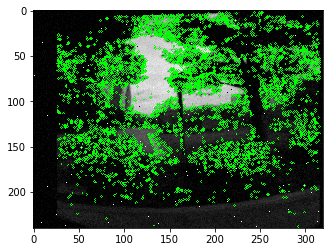

2 {'image': {'raw': {'img': tensor([[[[0.0941, 0.0784, 0.0784,  ..., 0.0431, 0.0627, 0.0510],
          [0.0863, 0.0784, 0.0784,  ..., 0.0510, 0.0549, 0.0471],
          [0.0706, 0.0667, 0.0667,  ..., 0.0431, 0.0588, 0.0431],
          ...,
          [0.0941, 0.0863, 0.0941,  ..., 0.0588, 0.0510, 0.0431],
          [0.0902, 0.0941, 0.0902,  ..., 0.0588, 0.0431, 0.0431],
          [0.0941, 0.0941, 0.0902,  ..., 0.0431, 0.0471, 0.0510]]]]), 'kpts': [tensor([[  1,  47],
        [  1,  47],
        [  2, 181],
        ...,
        [ 24, 218],
        [193, 208],
        [ 88, 231]], dtype=torch.int32)], 'kpts_map': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32)}, 'warp': {'img': tensor([[[[0.0225, 0.0146, 0.0735,  ..., 0.0578, 0.0146, 0.0539],
          [0.0146, 0.0578, 0.0146,  ..., 0.0303, 0.0

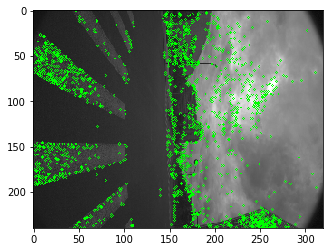

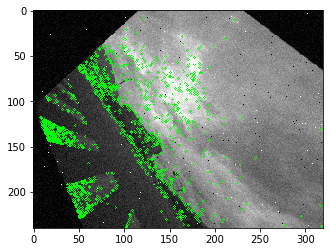

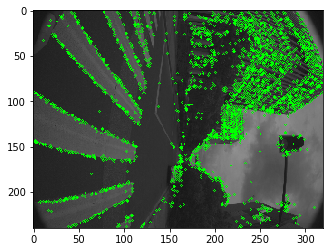

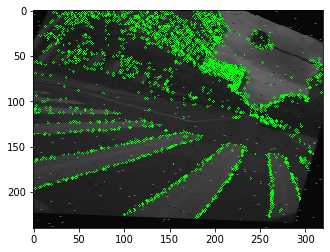

3 {'image': {'raw': {'img': tensor([[[[0.0941, 0.0784, 0.0784,  ..., 0.0431, 0.0627, 0.0510],
          [0.0863, 0.0784, 0.0784,  ..., 0.0510, 0.0549, 0.0471],
          [0.0706, 0.0667, 0.0667,  ..., 0.0431, 0.0588, 0.0431],
          ...,
          [0.0941, 0.0863, 0.0941,  ..., 0.0588, 0.0510, 0.0431],
          [0.0902, 0.0941, 0.0902,  ..., 0.0588, 0.0431, 0.0431],
          [0.0941, 0.0941, 0.0902,  ..., 0.0431, 0.0471, 0.0510]]]]), 'kpts': [tensor([[  1,  47],
        [  1,  47],
        [  2, 181],
        ...,
        [ 24, 218],
        [193, 208],
        [ 88, 231]], dtype=torch.int32)], 'kpts_map': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32)}, 'warp': {'img': tensor([[[[0.0373, 0.0402, 0.0554,  ..., 0.0378, 0.0353, 0.0402],
          [0.0353, 0.0441, 0.0651,  ..., 0.0353, 0.0

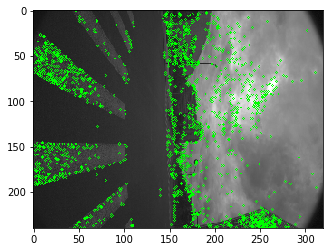

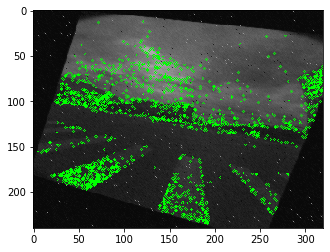

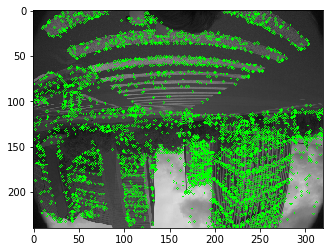

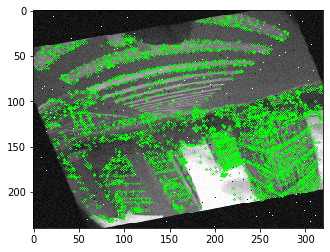

4 {'image': {'raw': {'img': tensor([[[[0.0941, 0.0784, 0.0784,  ..., 0.0431, 0.0627, 0.0510],
          [0.0863, 0.0784, 0.0784,  ..., 0.0510, 0.0549, 0.0471],
          [0.0706, 0.0667, 0.0667,  ..., 0.0431, 0.0588, 0.0431],
          ...,
          [0.0941, 0.0863, 0.0941,  ..., 0.0588, 0.0510, 0.0431],
          [0.0902, 0.0941, 0.0902,  ..., 0.0588, 0.0431, 0.0431],
          [0.0941, 0.0941, 0.0902,  ..., 0.0431, 0.0471, 0.0510]]]]), 'kpts': [tensor([[  1,  47],
        [  1,  47],
        [  2, 181],
        ...,
        [ 24, 218],
        [193, 208],
        [ 88, 231]], dtype=torch.int32)], 'kpts_map': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32)}, 'warp': {'img': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0

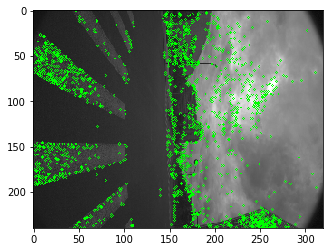

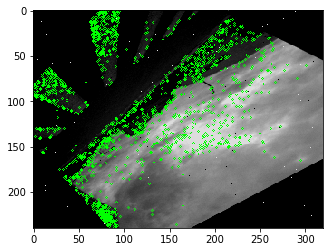

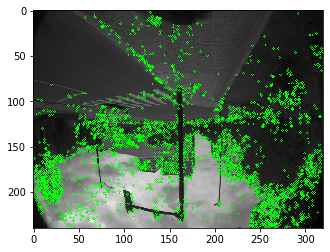

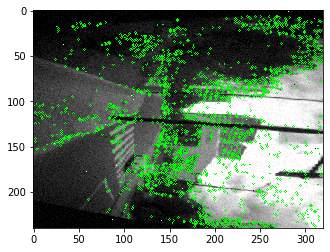

Done


In [3]:
if __name__=='__main__':
    with open('/Users/zhouchang/Documents/GitHub/SuperPoint-Pytorch/config/superpoint_train.yaml','r') as fin:
        config = yaml.safe_load(fin)

    selfdata = SelfDataset(config['data'],True)
    cdataloader = DataLoader(selfdata,collate_fn=selfdata.batch_collator,batch_size=1,shuffle=True)

    for i,d in enumerate(cdataloader):
        if i>=5:
            break
        print(i, d)
        img = (d['image']['raw']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img = cv2.merge([img, img, img])
        img_warp = (d['image']['warp']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img_warp = cv2.merge([img_warp, img_warp, img_warp])
        img1 = (d['image1']['raw']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img1 = cv2.merge([img1, img1, img1])
        img_warp1 = (d['image1']['warp']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img_warp1 = cv2.merge([img_warp1, img_warp1, img_warp1])
        kpts = np.where(d['image']['raw']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img, (kp[1], kp[0]), radius=1, color=(0,255,0))
        kpts = np.where(d['image']['warp']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img_warp, (kp[1], kp[0]), radius=1, color=(0,255,0))
        kpts = np.where(d['image1']['raw']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img1, (kp[1], kp[0]), radius=1, color=(0,255,0))
        kpts = np.where(d['image1']['warp']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img_warp1, (kp[1], kp[0]), radius=1, color=(0,255,0))
        plt.imshow(img)
        plt.show()
        plt.imshow(img_warp)
        plt.show()
        plt.imshow(img1)
        plt.show()
        plt.imshow(img_warp1)
        plt.show()
        
    print('Done')

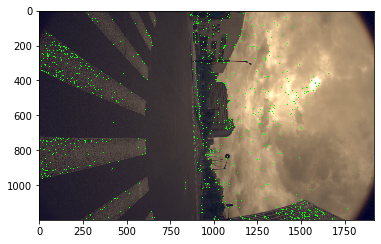

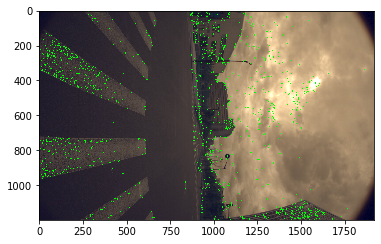

In [4]:
img = cv2.imread('/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/1377155868.png').squeeze().astype(np.int).astype(np.uint8)
kpts = np.load('/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/keypoints/1377155868.npy').astype(np.float32)

for kp in kpts:
    cv2.circle(img, (int(kp[0]+0.5), int(kp[1]+0.5)), radius=3, color=(0,255,0))
plt.imshow(img)
plt.show()

for kp in kpts:
    cv2.circle(img, (int(kp[0]), int(kp[1])), radius=3, color=(0,255,0))
plt.imshow(img)
plt.show()

In [6]:
# loss test
with open('/Users/zhouchang/Documents/GitHub/SuperPoint-Pytorch/config/superpoint_train.yaml','r') as fin:
        config = yaml.safe_load(fin)

selfdata = SelfDataset(config['data'],True)
cdataloader = DataLoader(selfdata,collate_fn=selfdata.batch_collator,batch_size=config['solver']['train_batch_size'],shuffle=True)

for i, data in enumerate(cdataloader):
    if i>=5:
        break
    des = torch.rand([config['solver']['train_batch_size'],256,240,320])
    des1 = torch.rand([config['solver']['train_batch_size'], 256,240,320])
    print(descriptor_loss(config['solver'],data['image']['warp']['kpts'],data['image1']['warp']['kpts'],des,des1,data['pairs'],data['masks'],device='cpu'))

/Users/zhouchang/Documents/GitHub/SuperPoint-Pytorch/solver/sfm_loss.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor(11011.7715)
tensor(11010.8242)
tensor(11007.8623)
tensor(11020.5010)
tensor(11008.0625)
